In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np


In [3]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'


In [4]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-10-01 11:41:09.639092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-01 11:41:09.683760: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-01 11:41:09.683797: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:

NUM_CLASSES = 9
BATCH_SIZE = 8
LEARNING_RATE = 1e-4

try:
    set_global_policy('float32')  # Use float32 to avoid CPU fallback issues
    print("✅ Mixed Precision disabled — using float32 for stability.")
except Exception as e:
    print(f"⚠️ Precision setup failed: {e}")


✅ Mixed Precision disabled — using float32 for stability.


In [6]:
def build_model(num_classes):
    inputs = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False  # Freeze base for transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)
    return model

In [7]:
model = build_model(NUM_CLASSES)
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

2025-10-01 11:41:09.740299: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-01 11:41:09.740383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-01 11:41:09.740400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-01 11:41:09.897394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-01 11:41:09.897431: I external/local_xla/xla/stream_executor

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Path to your dataset
DATASET_PATH = "./dataset"

# Load training and validation datasets
train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"  # Ensures one-hot encoding
)

val_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)
     

Found 39000 files belonging to 9 classes.
Using 31200 files for training.
Found 39000 files belonging to 9 classes.
Using 7800 files for validation.


In [10]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:


# Load raw training dataset (no shuffle, no map, no prefetch)
raw_train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Extract labels batch-by-batch (memory-safe)
class_indices = []
for _, label_batch in raw_train_ds:
    class_indices.extend(tf.argmax(label_batch, axis=1).numpy())

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_indices),
    y=class_indices
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Found 39000 files belonging to 9 classes.
Using 31200 files for training.
Class weights: {0: 1.0846891948268669, 1: 1.0853683990816114, 2: 1.0949673615498, 3: 1.0766045548654244, 4: 1.082656672912763, 5: 1.0949673615498, 6: 1.1613623673925182, 7: 0.5726241603347649, 8: 1.1490443044967407}


2025-10-01 11:44:06.400834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:

# Define early stopping
early_exit = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
# Train the model
EPOCHS = 50  # Set high, early stopping will cut it short if needed

try:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weights_dict,
        callbacks=[early_exit, lr_scheduler]
    )
except Exception as e:
    print(f"⚠️ Training crashed: {e}")



Epoch 1/50


I0000 00:00:1759319050.605825   18128 service.cc:145] XLA service 0x7a9e680050a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759319050.605889   18128 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-10-01 11:44:10.710583: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1759319050.748318   18128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-10-01 11:44:14.565459: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759319056.059724   18219 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5646', 528 bytes spill stores, 380 bytes spill loads



3900/3900 ━━━━━━━━━━━━━━━━━━━━ 197s 48ms/step - accuracy: 0.2651 - loss: 2.0620 - val_accuracy: 0.4054 - val_loss: 1.6621 - learning_rate: 1.0000e-04
Epoch 2/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 134s 33ms/step - accuracy: 0.4012 - loss: 1.7502 - val_accuracy: 0.5047 - val_loss: 1.4996 - learning_rate: 1.0000e-04
Epoch 3/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 141s 35ms/step - accuracy: 0.4568 - loss: 1.6146 - val_accuracy: 0.5258 - val_loss: 1.4282 - learning_rate: 1.0000e-04
Epoch 4/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 267s 67ms/step - accuracy: 0.4840 - loss: 1.5376 - val_accuracy: 0.5774 - val_loss: 1.3178 - learning_rate: 1.0000e-04
Epoch 5/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 232s 58ms/step - accuracy: 0.5108 - loss: 1.4644 - val_accuracy: 0.5924 - val_loss: 1.2645 - learning_rate: 1.0000e-04
Epoch 6/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 222s 56ms/step - accuracy: 0.5318 - loss: 1.4145 - val_accuracy: 0.5909 - val_loss: 1.2488 - learning_rate: 1.0000e-04
Epoch 7/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 151

2025-10-01 12:54:24.161890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 249 of 256


   1/3900 ━━━━━━━━━━━━━━━━━━━━ 11:29:35 11s/step - accuracy: 0.5000 - loss: 1.3098

2025-10-01 12:54:24.554397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3900/3900 ━━━━━━━━━━━━━━━━━━━━ 223s 54ms/step - accuracy: 0.6462 - loss: 1.0555 - val_accuracy: 0.7087 - val_loss: 0.9083 - learning_rate: 1.0000e-04
Epoch 24/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 172s 43ms/step - accuracy: 0.6534 - loss: 1.0389 - val_accuracy: 0.7158 - val_loss: 0.8903 - learning_rate: 1.0000e-04
Epoch 25/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 165s 41ms/step - accuracy: 0.6531 - loss: 1.0316 - val_accuracy: 0.7232 - val_loss: 0.8791 - learning_rate: 1.0000e-04
Epoch 26/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 173s 43ms/step - accuracy: 0.6552 - loss: 1.0206 - val_accuracy: 0.7313 - val_loss: 0.8590 - learning_rate: 1.0000e-04
Epoch 27/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 148s 37ms/step - accuracy: 0.6621 - loss: 1.0125 - val_accuracy: 0.7200 - val_loss: 0.8711 - learning_rate: 1.0000e-04
Epoch 28/50
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 205s 51ms/step - accuracy: 0.6684 - loss: 0.9989 - val_accuracy: 0.7321 - val_loss: 0.8528 - learning_rate: 1.0000e-04
Epoch 29/50
3900/3900 ━━━━━━━━━━━━━━━━━━

In [13]:
model.save("resnet50_cancer_model-version-2.keras")

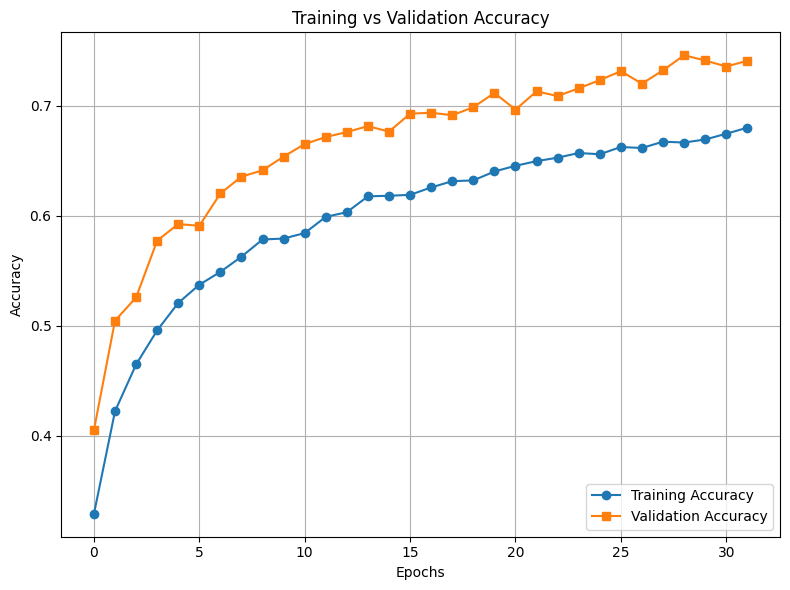

In [14]:
import matplotlib.pyplot as plt

# Extract accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(len(acc))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
